# Calculs statistiques ‘privacy by design’ pour le Cloud Personnel

Idée : créer une web_app ou une application python permettant de déposer une image et d'avoir toutes les images qui sont similaires.

## Lib pour le projet

In [1]:
import glob
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statistics
import tensorflow as tf
import tensorflow_hub as hub

from community import community_louvain
from PIL import Image
from scipy.spatial import distance

2022-12-04 11:21:53.666158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 11:21:53.759959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 11:21:53.759974: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 11:21:54.181828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Models

In [2]:
model_google_1 = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
                                                     trainable=False, arguments=dict(batch_norm_momentum=0.997))])

2022-12-04 11:21:54.777666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 11:21:54.777931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 11:21:54.777977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-04 11:21:54.778012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-04 11:21:54.778046: W tensorflow/c

In [3]:
model_google_2 = tf.keras.Sequential([hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable=False)])

In [4]:
model_google_3 = tf.keras.Sequential([hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5", trainable=False,
    arguments=dict(batch_norm_momentum=0.997))])

In [5]:
model_tensorflow_1 = tf.keras.Sequential(
    [hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2", input_shape=(224, 224) + (3,))])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Extraction et mise en forme

In [6]:
def extract(model, file, size):
    file = Image.open(file).convert('L').resize(size)
    # display(file)

    file = np.stack((file,) * 3, axis=-1)
    file = np.array(file) / 255.0

    embedding = model.predict(file[np.newaxis, ...])
    # print(embedding)
    vgg16_feature_np = np.array(embedding)
    flattended_feature = vgg16_feature_np.flatten()

    # print(len(flattended_feature))
    # print(flattended_feature)
    # print('-----------')
    return flattended_feature

In [7]:
images_paths = sorted(glob.glob("./images/*"))
images_names = list(map(lambda image_name: re.search(r'/([a-zA-Z0-9]+)\.', image_name).group()[1:-1], images_paths))

In [8]:
extract_images_google_1 = []
extract_images_google_2 = []
extract_images_google_3 = []
extract_tensorflow_1 = []

for image in images_paths:
    extract_images_google_1.append(extract(model_google_1, image, (299, 299)))
    extract_images_google_2.append(extract(model_google_2, image, (224, 224)))
    extract_images_google_3.append(extract(model_google_3, image, (224, 224)))
    extract_tensorflow_1.append(extract(model_tensorflow_1, image, (224, 224)))

1/1 [==============================] - 0s 24ms/step


## Comparaison de distance

In [9]:
def generate_data_frame(extract_images, metric, name_images):
    dict_res = {}

    for index, image_1 in enumerate(extract_images):
        res = []
        for image_2 in extract_images:
            dc = distance.cdist([image_1], [image_2], metric)[0]
            res.append(dc[0])

        dict_res[name_images[index]] = res

    dataframe = pd.DataFrame(data=dict_res)
    dataframe.index = images_names

    return dataframe

In [10]:
def generate_group(dataframe, limite):
    groupes = {}

    for index_y, image_y in enumerate(dataframe):
        similaire = []
        pos = 0
        for index_x, image_x in enumerate(dataframe):
            res = dataframe.iat[index_y, index_x]
            if res <= limite and index_y != index_x:
                similaire.append(image_x)
        if len(similaire) != 0:
            groupes[image_y] = similaire
        pos += 1

    return groupes

In [11]:
def generate_group_stat(dataframe, limite):
    groupes = {}

    for index_y, image_y in enumerate(dataframe):
        similaire = {}
        pos = 0
        for index_x, image_x in enumerate(dataframe):
            res = dataframe.iat[index_y, index_x]
            if res <= limite and index_y != index_x:
                similaire[image_x] = round(res, 2)
        if len(similaire) != 0:
            groupes[image_y] = similaire
        pos += 1

    return groupes

In [12]:
def plot_result(dataframe):
    plt.figure(figsize=(50, 20))
    sns.heatmap(dataframe, annot=True, fmt=".2f")
    plt.show()

In [13]:
def stats(groupe):
    content = {}
    for nom_image in groupe:
        score = 0
        for images in groupe[nom_image]:
            score += 1 if re.search(r'[a-zA-Z]+', nom_image).group() == re.search(r'[a-zA-Z]+', images).group() else 0
        content[nom_image] = f"{score}/{len(groupe[nom_image])}"

    return content

In [14]:
def find_clusters(vectors, metric, limit, names):
    clusters = {}
    for index1, v1 in enumerate(vectors):
        cluster_type = re.search(r'[a-zA-Z]+', str(names[index1])).group()
        if not cluster_type in clusters.keys():
            clusters[cluster_type] = []
        for index2, v2 in enumerate(vectors):
            d = distance.cdist([v1], [v2], metric)[0]
            if limit > d[0] > 0.0001:
                if names[index2] not in clusters[cluster_type]:
                    clusters[cluster_type].append(names[index2])
    return clusters

In [15]:
def get_precision(cluster):
    l = []
    for key, value in cluster.items():
        nb_correct = 0
        for v in value:
            if re.search(r'[a-zA-Z]+', v).group() == key:
                nb_correct += 1
        l.append((nb_correct / len(value)) if len(value) != 0 else 0)
    return l

In [16]:
def get_recall(cluster, names):
    l = []
    for key, value in cluster.items():
        nb_correct = 0
        for v in value:
            if re.search(r'[a-zA-Z]+', v).group() == key:
                nb_correct += 1
        len_list = [re.search(r'[a-zA-Z]+', i).group() for i in names if re.search(r'[a-zA-Z]+', i).group() == key]
        l.append((nb_correct / len(len_list)) if len(len_list) != 0 else 0)
    return l

In [17]:
def get_f1_score(precision_scores, recall_scores):
    l = []
    for p, r in zip(precision_scores, recall_scores):
        l.append((2 * ((p * r) / (p + r))) if p + r != 0 else 0)
    return l

In [18]:
def get_accuracy(f1_scores):
    return statistics.mean(f1_scores)

In [19]:
def plot_accuracy(extract_images, names):
    score = []
    optimal_accuracy, optimal_limite = 0, 0

    for limit in np.arange(0.1, 0.95, 0.05):
        clusters = find_clusters(extract_images, 'cosine', limit, names)
        precision = get_precision(clusters)
        recall = get_recall(clusters, names)
        f1_score = get_f1_score(precision, recall)
        accuracy = get_accuracy(f1_score)
        optimal_accuracy, optimal_limite = (accuracy, limit) if optimal_accuracy < accuracy else (optimal_accuracy, optimal_limite)
        score.append(accuracy)

    df_accuracy = pd.DataFrame({'score': score, 'limit': np.arange(0.1, 0.95, 0.05)})
    sns.lineplot(data=df_accuracy, x="limit", y="score")

    return optimal_limite, df_accuracy

In [20]:
# Matrice de confusion pour chaque catégorie
def matrice(cf_matrix, categories):
    plt_x = 0
    fig, axes = plt.subplots(1, len(categories), figsize=(20, 3))
    fig.suptitle('Matrice de confusion')

    for matrix, categorie in zip(cf_matrix, categories):
        ax = sns.heatmap(matrix / np.sum(matrix), fmt='.2%', annot=True, cmap='Purples', ax=axes[plt_x])
        ax.set_ylabel('\nPrédiction')
        ax.set_xlabel('Valeur actuelle')
        ax.xaxis.set_ticklabels([categorie, f'Non {categorie}'])
        ax.yaxis.set_ticklabels([categorie, f'Non {categorie}'])

        plt_x = plt_x + 1

In [21]:
def nb_pred(cluster, names):
    TP, TN, FN, FP = 0, 0, 0, 0
    categories = []
    matrix = []
    for key, value in cluster.items():
        for v in value:
            if re.search(r'[a-zA-Z]+', v).group() == key:
                TP += 1
            else:
                FP += 1
        len_list = len([re.search(r'[a-zA-Z]+', i).group() for i in names if
                        re.search(r'[a-zA-Z]+', i).group() == key])
        FN = len_list - TP
        len_img = len(names)
        TN = len_img - len_list - FP
        cf_matrix = np.array([TP, FP, FN, TN])
        cf_matrix = cf_matrix.reshape(2, 2)
        TP, TN, FN, FP = 0, 0, 0, 0
        matrix.append(cf_matrix)
        categories.append(key)

    matrice(matrix, categories)

    plt.show()

### Modèle Google 1

In [22]:
df_cosine_google_1 = generate_data_frame(extract_images_google_1, 'cosine', images_names)

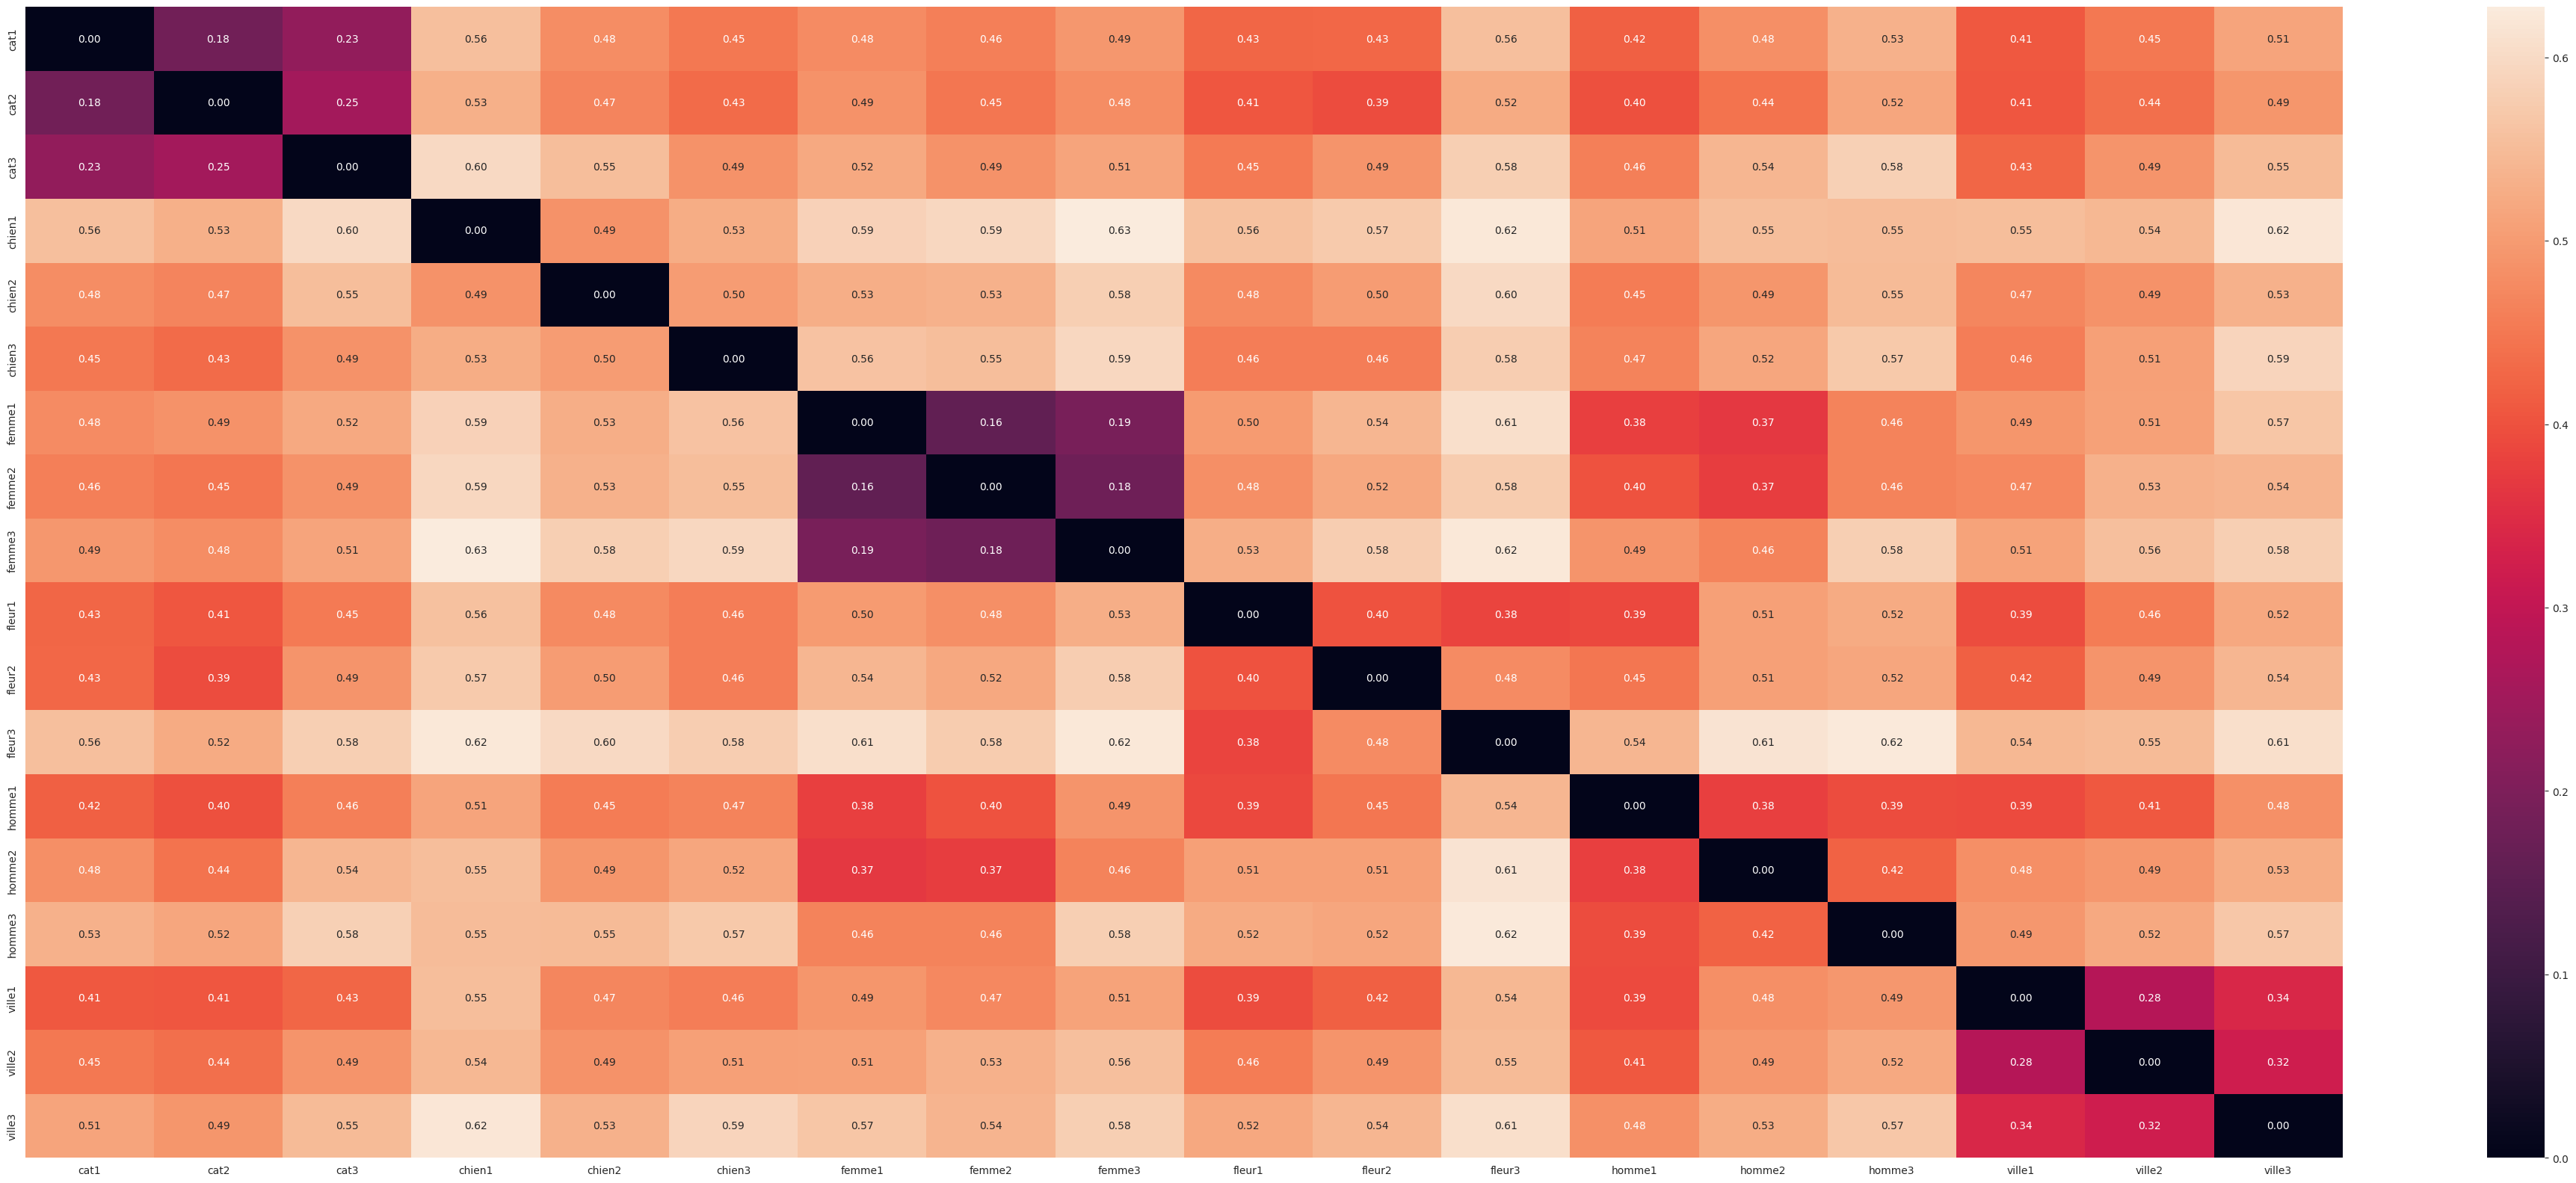

In [23]:
plot_result(df_cosine_google_1)

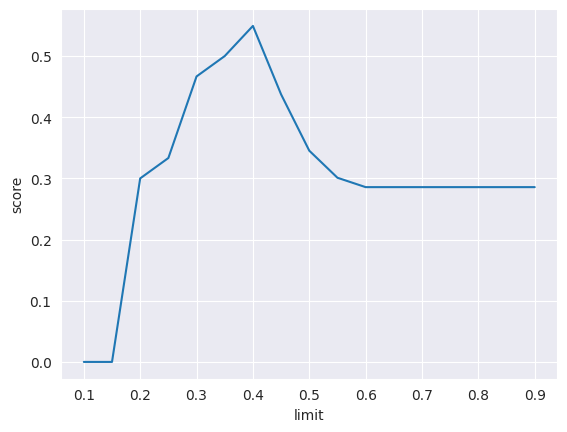

In [24]:
limite_google_1, df_google_1 = plot_accuracy(extract_images_google_1, images_names)

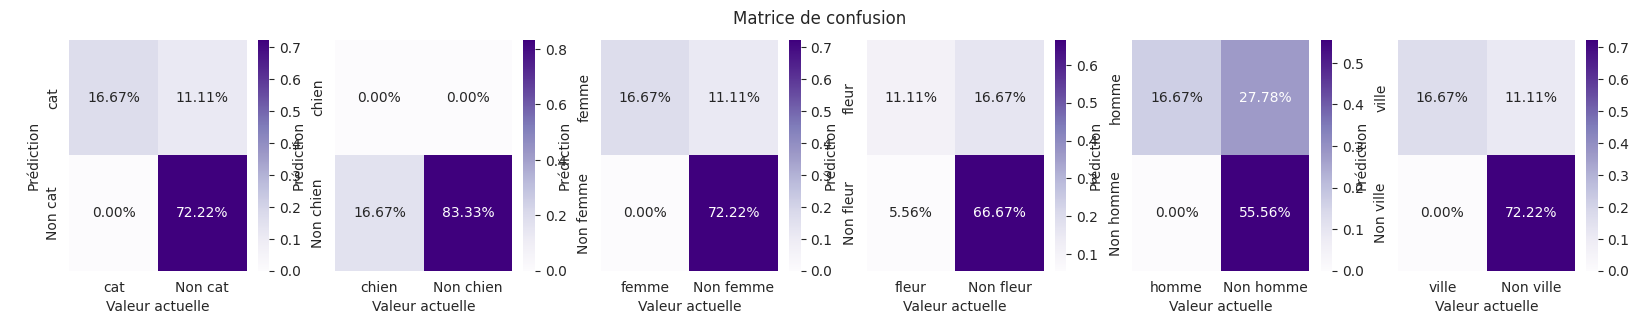

In [25]:
nb_pred(find_clusters(extract_images_google_1, 'cosine', limite_google_1, images_names), images_names)

In [26]:
# groupe_google_1 = generate_group(df_cosine_google_1, 0.4)
# stats(groupe_google_1)

In [27]:
# generate_group_stat(df_cosine_google_1, 0.3)

### Modèle Google 2

In [28]:
df_cosine_google_2 = generate_data_frame(extract_images_google_2, 'cosine', images_names)

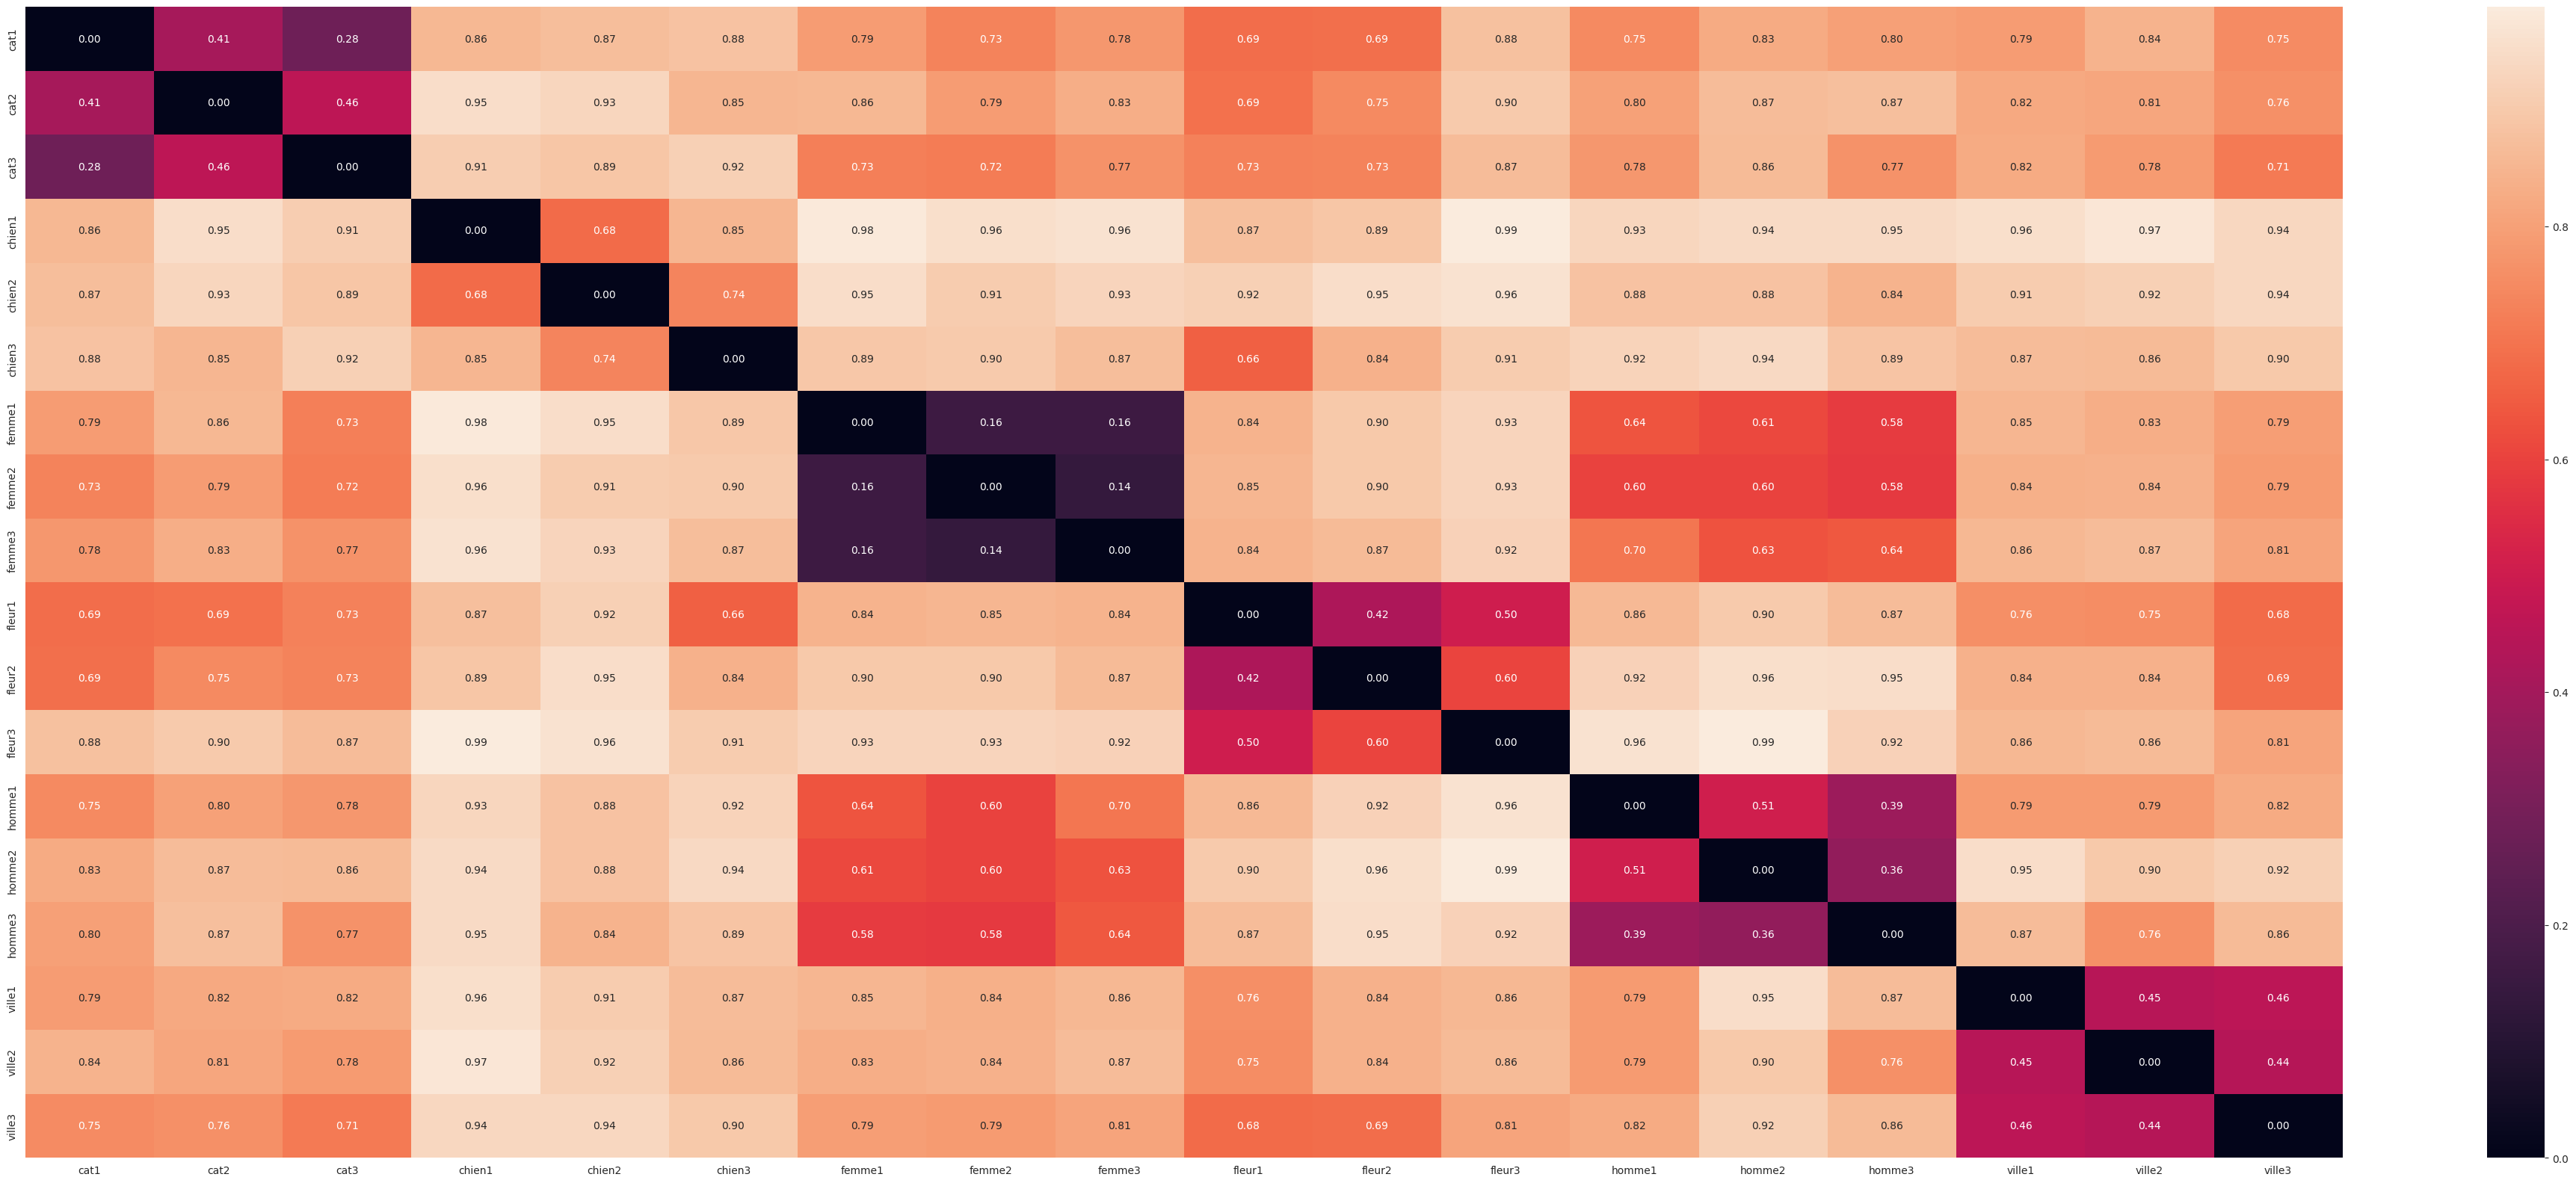

In [29]:
plot_result(df_cosine_google_2)

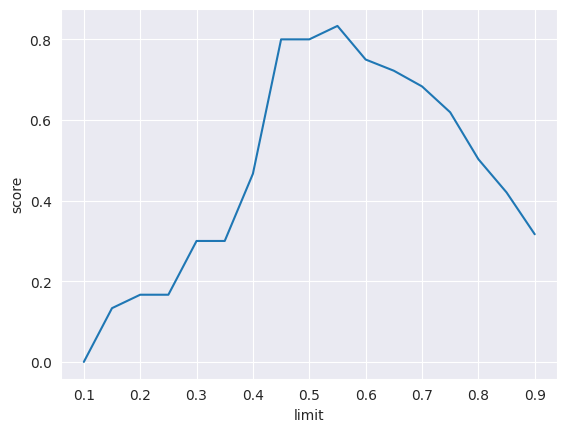

In [30]:
limite_google_2, df_google_2 = plot_accuracy(extract_images_google_2, images_names)

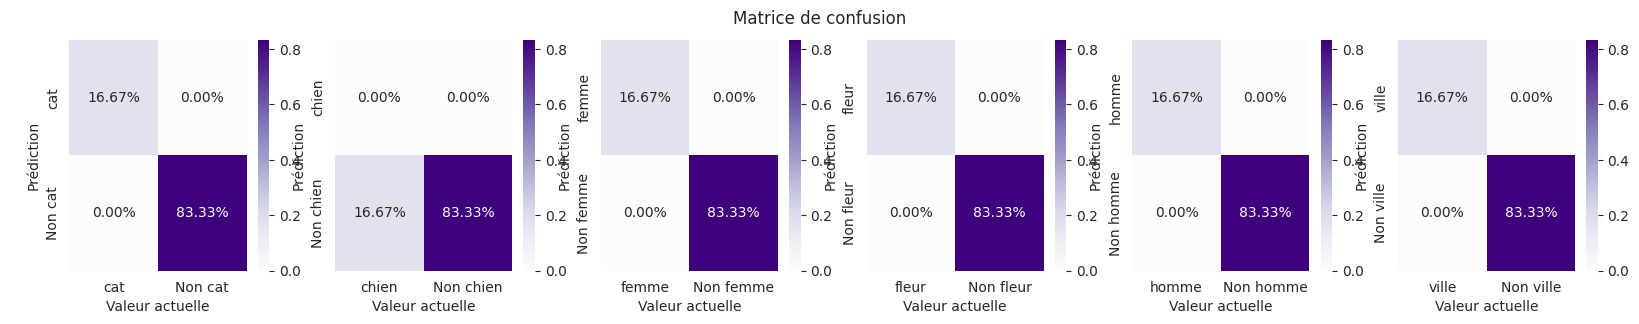

In [31]:
nb_pred(find_clusters(extract_images_google_2, 'cosine', limite_google_2, images_names), images_names)

In [32]:
# groupe_google_2 = generate_group(df_cosine_google_2, 0.75)
# stats(groupe_google_2)

In [33]:
# generate_group_stat(df_cosine_google_2, 0.4)

### Modèle Google 3

In [34]:
df_cosine_google_3 = generate_data_frame(extract_images_google_3, 'cosine', images_names)

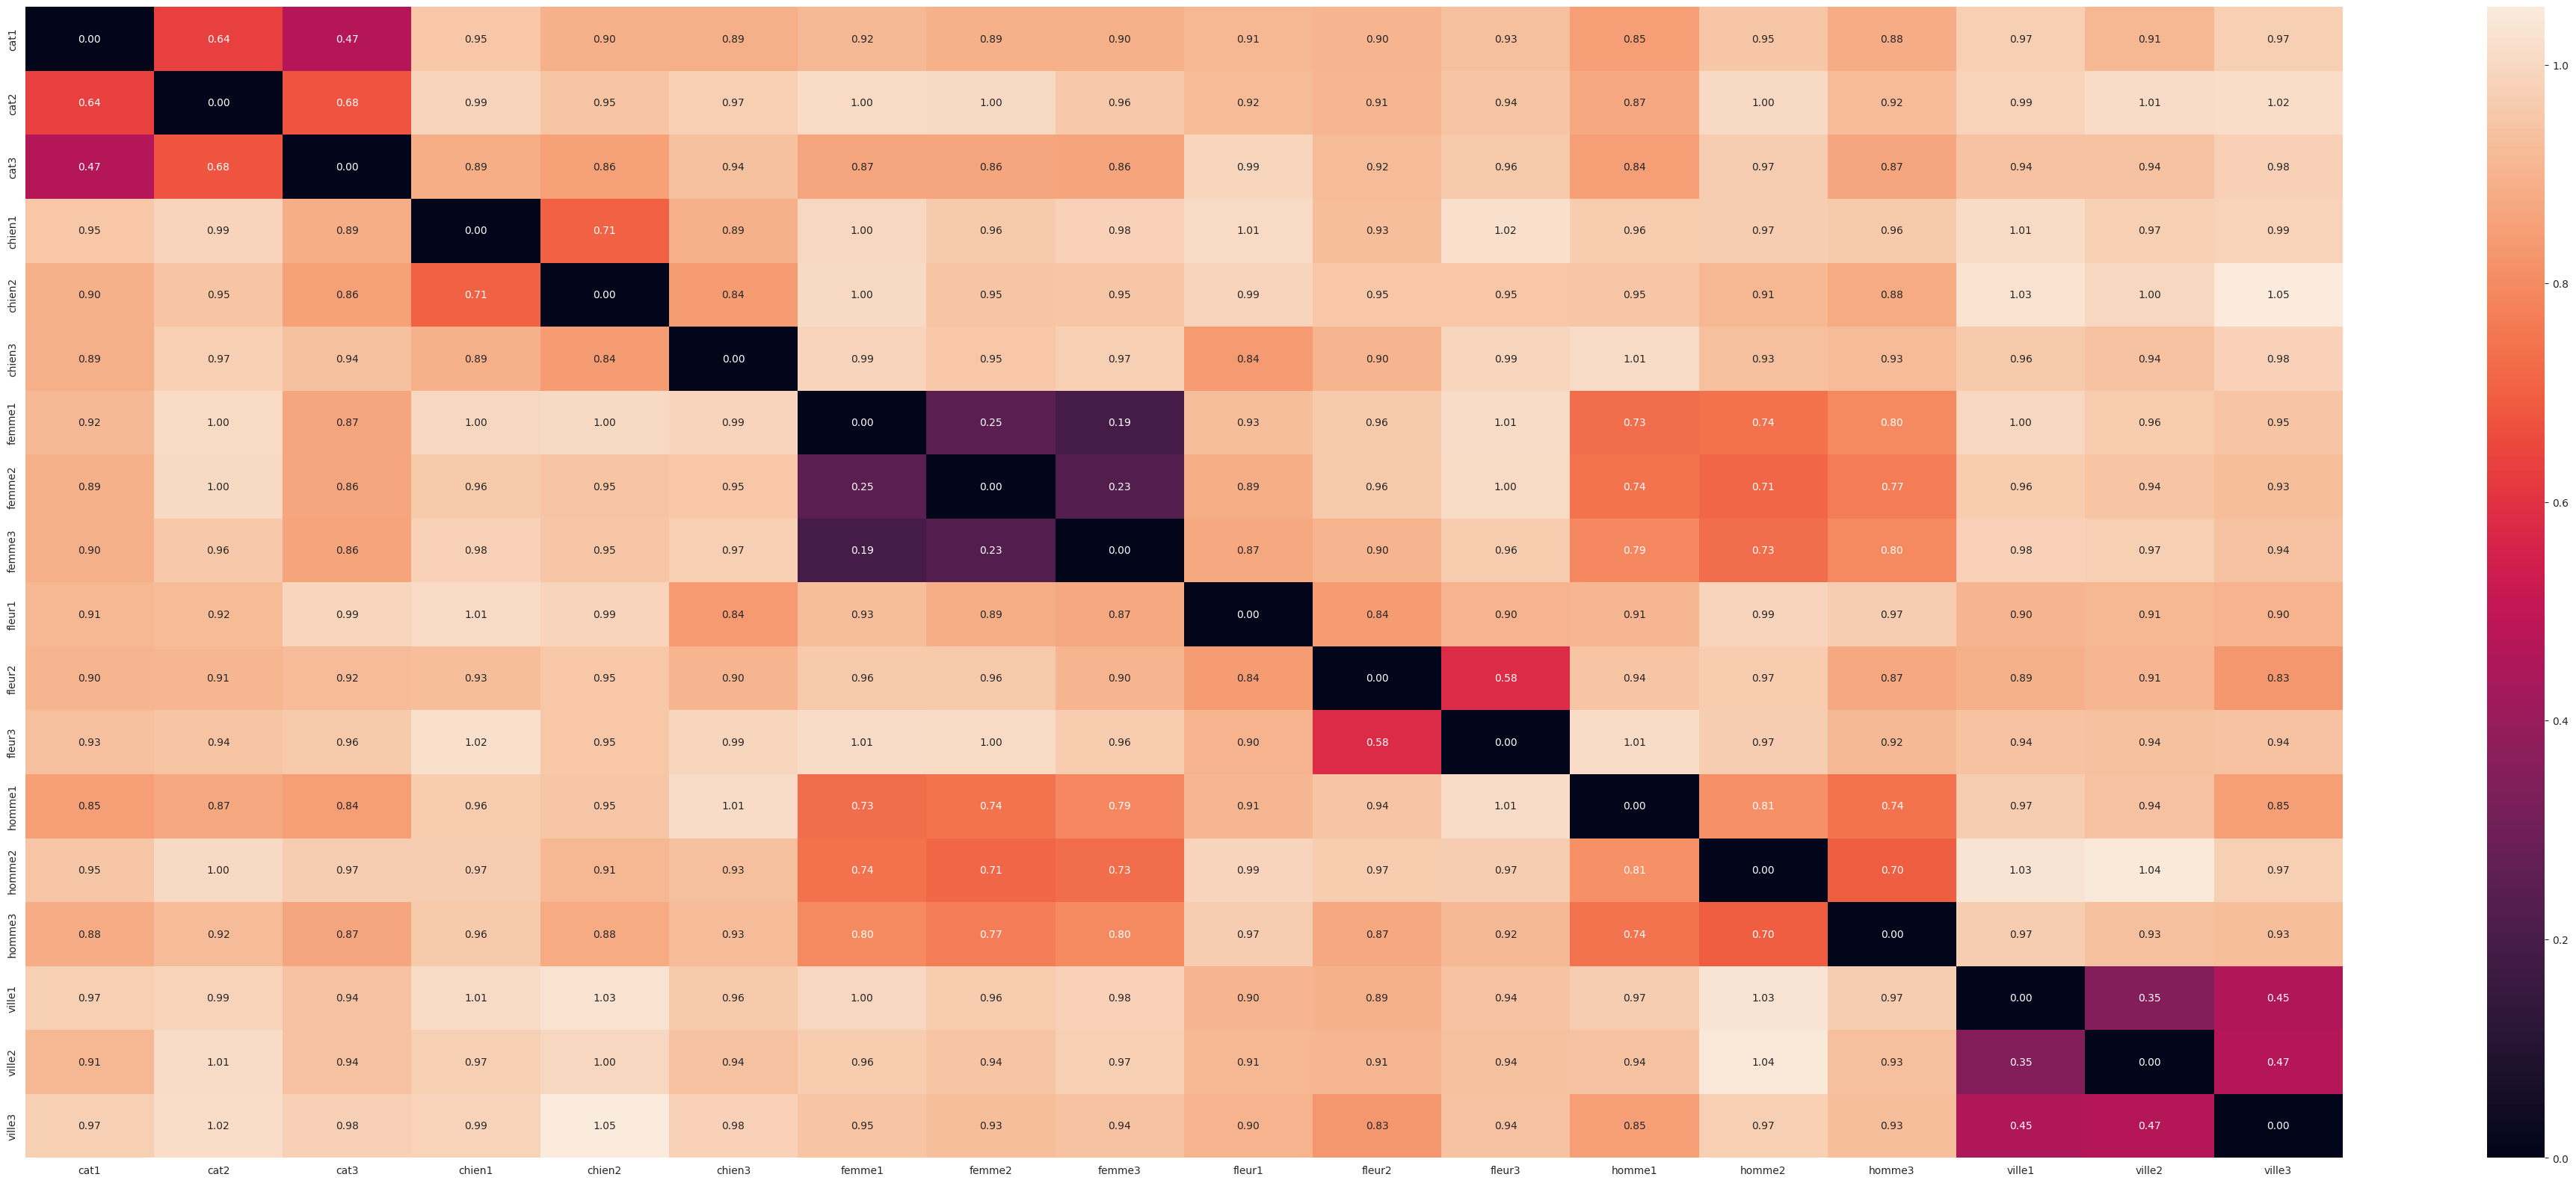

In [35]:
plot_result(df_cosine_google_3)

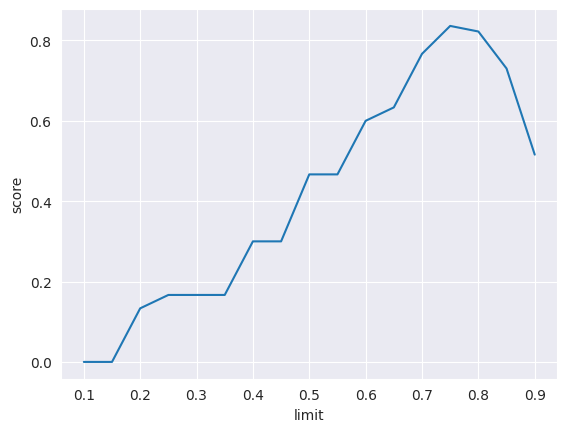

In [36]:
limite_google_3, df_google_3 = plot_accuracy(extract_images_google_3, images_names)

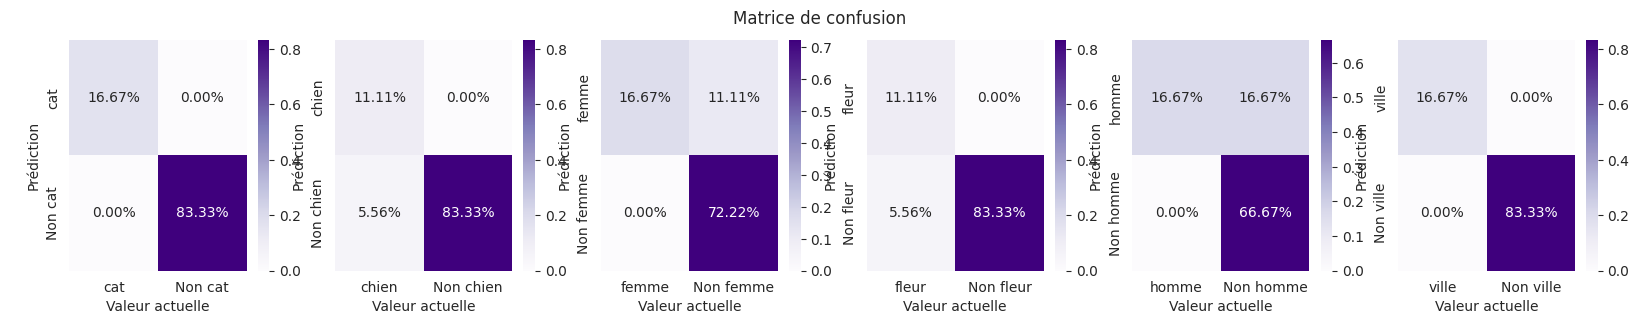

In [37]:
nb_pred(find_clusters(extract_images_google_3, 'cosine', limite_google_3, images_names), images_names)

In [38]:
# groupe_google_3 = generate_group(df_cosine_google_3, 0.8)
# stats(groupe_google_3)

In [39]:
# generate_group_stat(df_cosine_google_3, 0.7)

### Modèle Tensorflow

In [40]:
df_cosine_tensorflow_1 = generate_data_frame(extract_tensorflow_1, 'cosine', images_names)

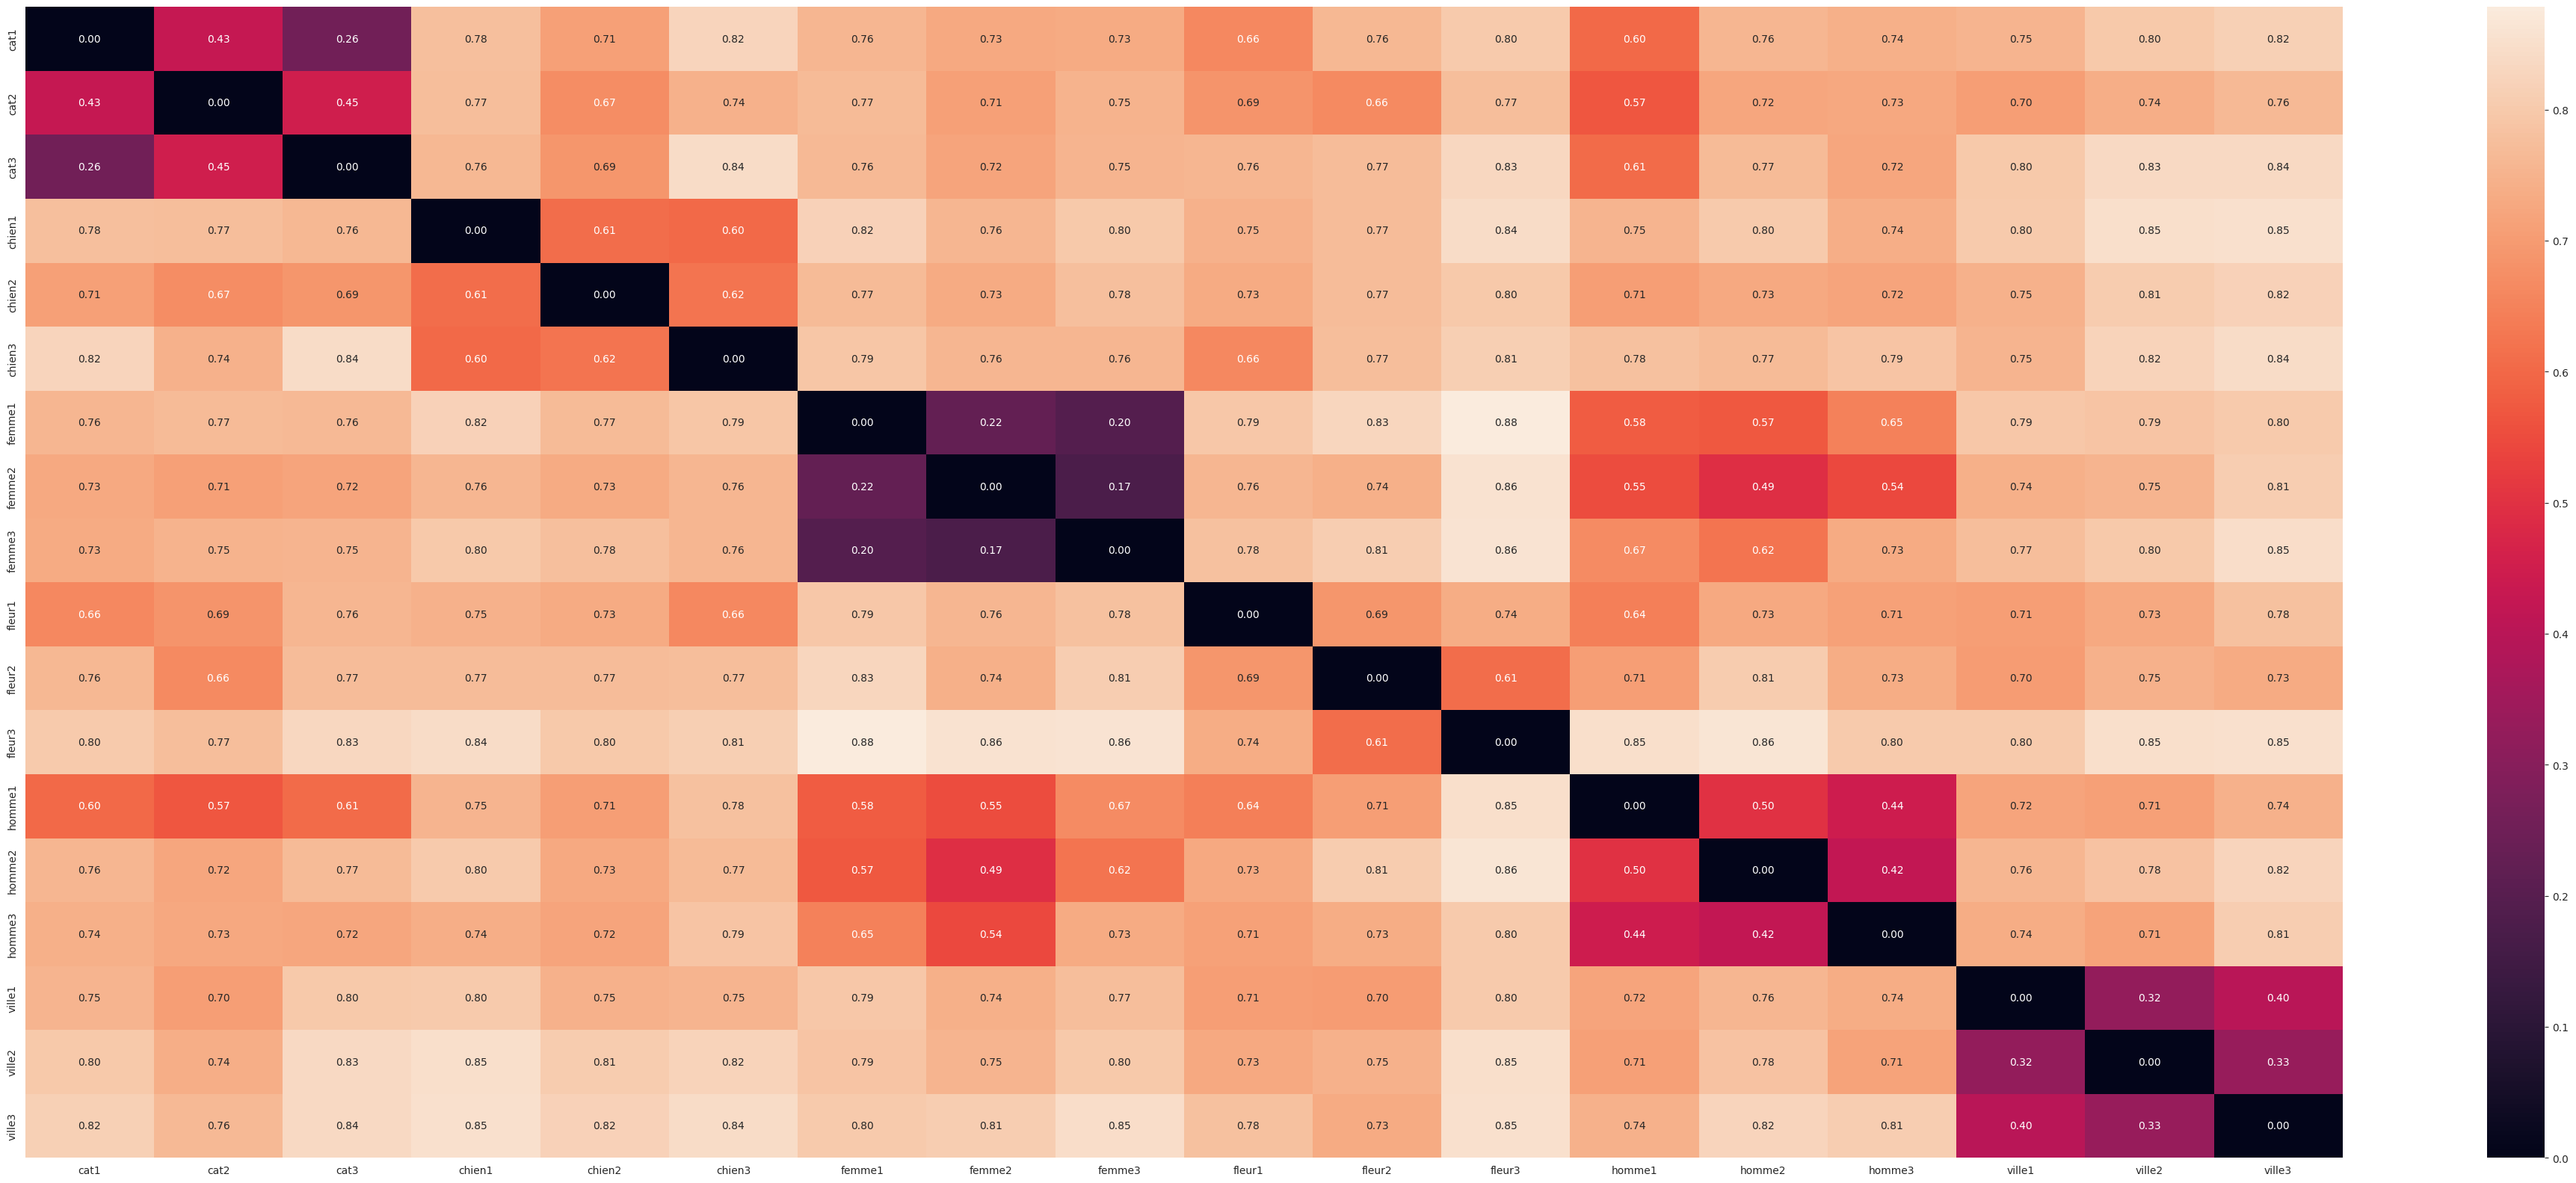

In [41]:
plot_result(df_cosine_tensorflow_1)

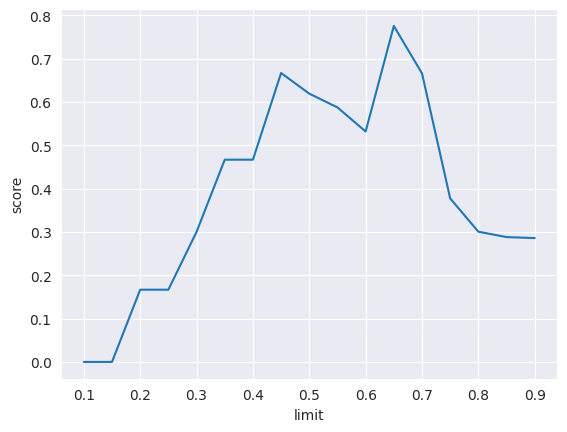

In [42]:
limite_tensorflow_1, df_tensorflow_1 = plot_accuracy(extract_tensorflow_1, images_names)

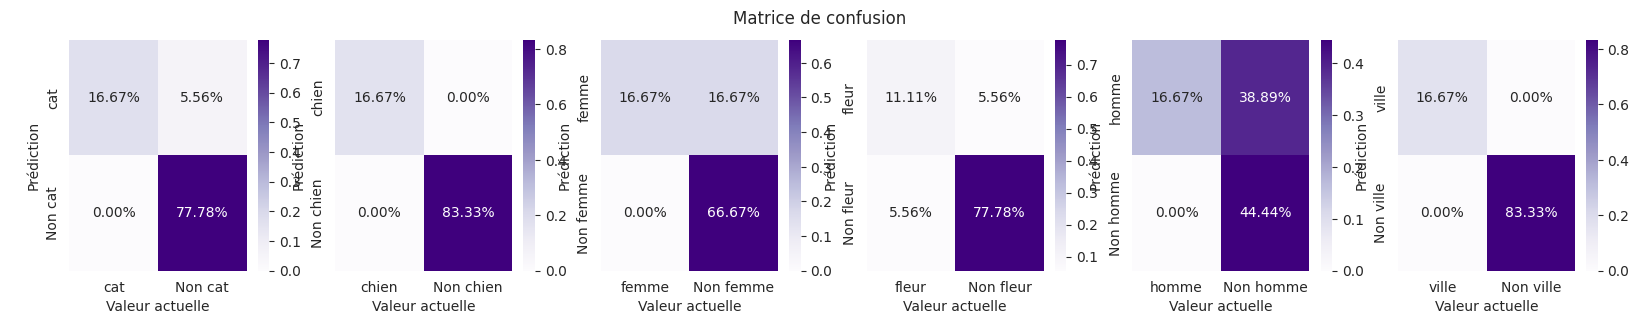

In [43]:
nb_pred(find_clusters(extract_tensorflow_1, 'cosine', round(limite_tensorflow_1, 2), images_names), images_names)

In [44]:
# groupe_tensorflow_1 = generate_group(df_cosine_tensorflow_1, 0.6)
# stats(groupe_tensorflow_1)

In [45]:
# generate_group_stat(df_cosine_tensorflow_1, 0.6)

## Comparaison des courbes d'accuracy entre les modèles

<AxesSubplot: xlabel='limit', ylabel='score'>

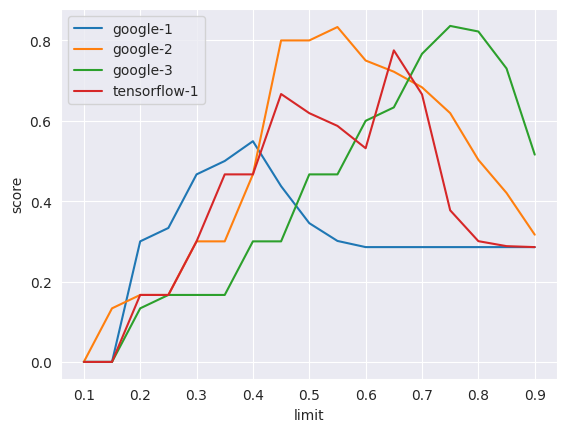

In [46]:
sns.lineplot(data=df_google_1, x="limit", y="score", label="google-1")
sns.lineplot(data=df_google_2, x="limit", y="score", label="google-2")
sns.lineplot(data=df_google_3, x="limit", y="score", label="google-3")
sns.lineplot(data=df_tensorflow_1, x="limit", y="score", label="tensorflow-1")

## Test de représentation sous forme de graphe de connexion

In [47]:
tab_g = []

for idx1 in range(len(df_cosine_tensorflow_1)):
    tab_i = []
    for idx2 in range(len(df_cosine_tensorflow_1)):
        valeur = df_cosine_tensorflow_1.iat[idx1, idx2]
        valeur = valeur if valeur >= 0.000001 else 0  #permet de remettre à zéro le score des mêmes images

        if valeur <= 0:
            tab_i.append(0)
        elif valeur <= 0.20:
            tab_i.append(4)
        elif valeur <= 0.30:
            tab_i.append(3)
        elif valeur <= 0.40:
            tab_i.append(2)
        elif valeur <= 0.50:
            tab_i.append(1)
        else:
            tab_i.append(0)

        # Façon basique
        # tab_i.append(1 if (score <= 0.50) and score >= 0.000001 else 0)

    tab_g.append(tab_i)

A = np.array(tab_g)
G = nx.from_numpy_array(A)

In [48]:
dic = {}

for idx, nom in enumerate(images_names):
    dic[idx] = nom

G = nx.relabel_nodes(G, dic)

In [49]:
def print_classique_graph(graphe, font_size=8, alpha=0.2, color='#A86CF3'):
    nx.draw(graphe, with_labels=False, font_size=font_size, alpha=alpha, node_color=color)
    plt.show()

In [50]:
def print_node_importance_graph(graphe, font_size=8, alpha=1, color='#F9CD45'):
    importance = dict(nx.degree(graphe))
    importance = [v * v * v + 40 for v in importance.values()]
    nx.draw(graphe, with_labels=True, font_size=font_size, alpha=alpha, node_color=color, node_size=importance)
    plt.show()

In [51]:
def print_edge_importance_graph(graphe, font_size=8, alpha=1, color='#E97EF7'):
    importance = dict(nx.degree(graphe))
    importance = [v * v * v + 40 for v in importance.values()]
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    position = nx.spring_layout(graphe)
    nx.draw(graphe, position, with_labels=True, font_size=font_size, alpha=alpha, node_color=color, edgelist=edges,
            edge_color=weights, width=weights * 3, edge_cmap=plt.cm.Blues, node_size=importance)
    plt.show()

In [52]:
def print_group_graph(graphe, font_size=8, alpha=0.3):
    # Identification des communautés
    partition = community_louvain.best_partition(graphe)
    G.add_nodes = partition
    position = nx.spring_layout(graphe)  # Identifier la structure du graph
    plt.figure(figsize=(10, 10))
    plt.axis('off')  # Pas d'axes

    # Les cercles
    nx.draw_networkx_nodes(graphe, position, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

    # Les traits
    nx.draw_networkx_edges(graphe, position, alpha=alpha)

    # Les labels (optionnel)
    nx.draw_networkx_labels(graphe, position, font_size=font_size)

    plt.show(graphe)

In [53]:
def print_circular_group_graph(graphe, font_size=3, node_size=10):
    plt.figure(figsize=(5, 5))
    pos = nx.circular_layout(graphe)
    partition = community_louvain.best_partition(graphe)

    nx.draw_networkx_labels(graphe, pos, font_size=font_size, font_color='white')
    nx.draw_circular(graphe, node_color=list(partition.values()), node_size=node_size)

    plt.show()

In [54]:
# print_classique_graph(G)

In [55]:
# print_node_importance_graph(G)

In [56]:
# print_edge_importance_graph(G)

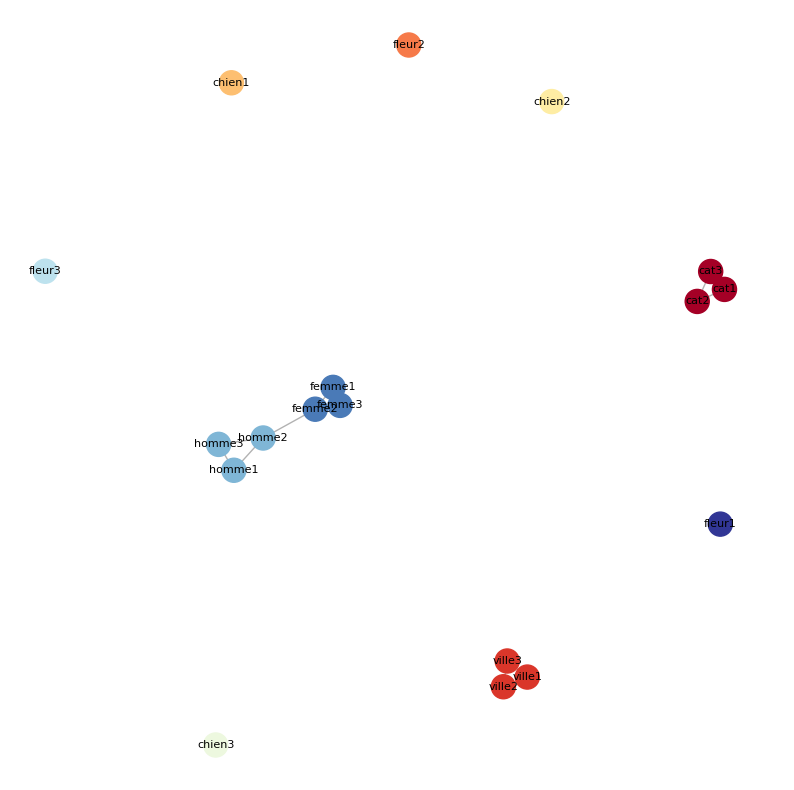

In [57]:
print_group_graph(G)

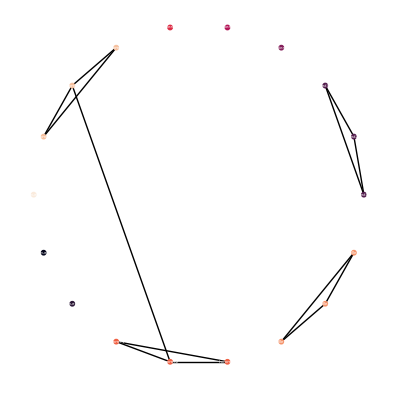

In [58]:
print_circular_group_graph(G)

## Les graphes sans les nœuds sans liens

In [59]:
df = pd.DataFrame(A, index=images_names, columns=images_names)

In [60]:
# Suppression des colonnes et lignes qu'avec des zéros
df = df.loc[~(df == 0).all(axis=1)]
df = df.T.loc[~(df.T == 0).all(axis=1)]

In [61]:
nom_img = df.columns

In [62]:
data = df.to_numpy()

In [63]:
dic = {}

for idx, nom in enumerate(nom_img):
    dic[idx] = nom

G = nx.from_numpy_array(data)
G = nx.relabel_nodes(G, dic)

In [64]:
# print_classique_graph(G)

In [65]:
# print_node_importance_graph(G)

In [66]:
# print_edge_importance_graph(G)

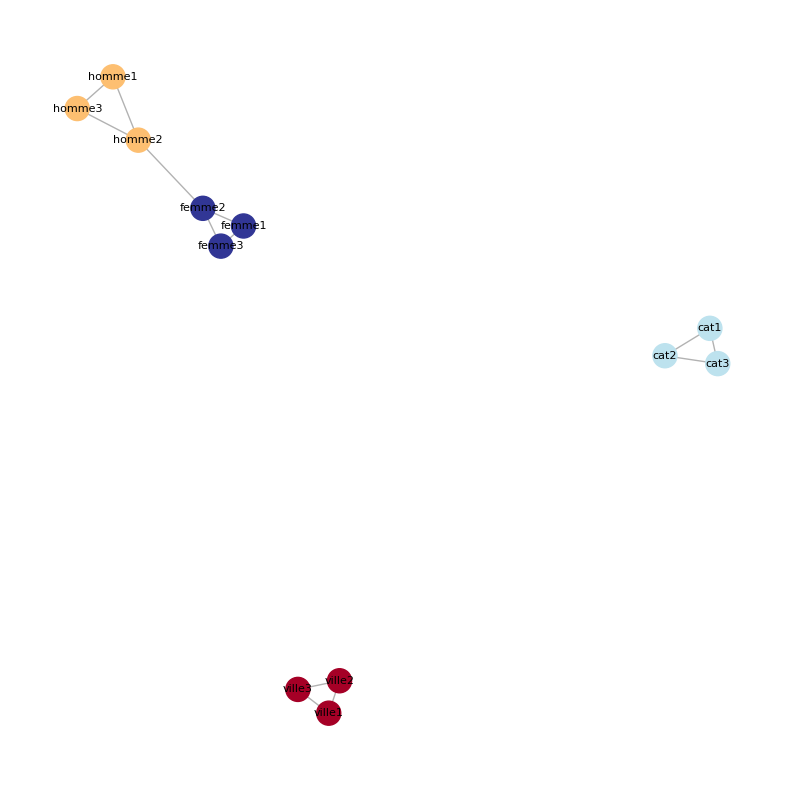

In [67]:
print_group_graph(G)

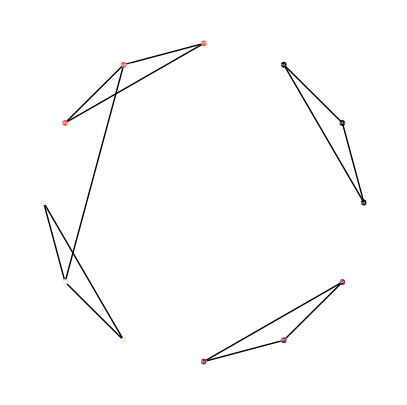

In [68]:
print_circular_group_graph(G)